# Forma deformada de la carpa de circo

$$
\newcommand{\ve}[1]{{\boldsymbol{#1}}}
\newcommand{\ma}[1]{{\boldsymbol{#1}}}
\newcommand{\hati}{\ve{\hat i}}
\newcommand{\hatj}{\ve{\hat j}}
\newcommand{\hatk}{\ve{\hat k}}
\newcommand{\hatr}{\ve{\hat r}}
\newcommand{\hatt}{\ve{\hat \theta}}
\newcommand{\hatp}{\ve{\hat \varphi}}
$$

In [1]:
from numpy import zeros, round, ix_, arange, sum, equal, array_equal, meshgrid, concatenate, sort, eye, reshape, fill_diagonal

import numpy as np

# este comando es para que las matrices se muestren completamente, con 300 caracteres por línea
np.set_printoptions(threshold=np.inf, linewidth=300)

%matplotlib ipympl
# Nota instale ipympl con el comando de consola:
# conda install -c conda-forge ipympl
# una vez la instale, dele click al boton recargar de su explorador
# NOTA: este procedimiento solo toca realizarlo una vez, después de esto la librería quedará permanentemente instalada en su computador

import matplotlib.pyplot as plt

from scipy.sparse import csc_array

Se define una función para calcular la matriz laplaciana discreta

In [2]:
def mi_delsq(M):
    # Calcula la matriz laplaciana discreta dada la matriz M
    # M contiene la numeración de los nodos
    Nfil, Ncol = M.shape         # número de filas y columnas
    num_nodos_int = sum(M != 0)  # número de nodos interiores

    # Se verifica que M sea una matriz de números enteros
    assert isinstance(M[0,0], np.int64), \
        "M debe ser un array dtype=int64"
    
    # Se verifica que no existan nodos con numeración repetida o incompleta
    assert array_equal(sort(M[M!=0]), arange(1, num_nodos_int+1)), \
        "Nodos incorrectamente numerados"

    # La diagonal de la matriz esta llena de cuatros
    L = zeros((num_nodos_int, num_nodos_int), int)
    fill_diagonal(L, 4)                            # fill in-place

    # Se asignan los -1 fuera de la diagonal
    for i in range(Nfil):
        for j in range(Ncol):
            k = M[i, j]     # número del nodo
            
            if k == 0:
                continue

            kW = M[i  , j-1]  # Recuerde los puntos cardinales:
            kN = M[i-1, j  ]  #              N
            kE = M[i  , j+1]  #            W   E    
            kS = M[i+1, j  ]  #              S   

            if kW != 0: L[k-1, kW-1] = -1
            if kN != 0: L[k-1, kN-1] = -1
            if kE != 0: L[k-1, kE-1] = -1
            if kS != 0: L[k-1, kS-1] = -1

    return csc_array(L)   # 316 ms se demora solve_qp()
    #return L             # 350 ms se demora solve_qp()

Se verifica el correcto funcionamiento de la función que acabamos de crear

In [3]:
m = 5
n = 7

M = zeros((m+2, n+2), dtype=int)
M[ix_(arange(1,m+1), arange(1,n+1))] = reshape(arange(1, m*n+1), (m, n), 'F')

M

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  6, 11, 16, 21, 26, 31,  0],
       [ 0,  2,  7, 12, 17, 22, 27, 32,  0],
       [ 0,  3,  8, 13, 18, 23, 28, 33,  0],
       [ 0,  4,  9, 14, 19, 24, 29, 34,  0],
       [ 0,  5, 10, 15, 20, 25, 30, 35,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [4]:
L = mi_delsq(M)

#L

Observemos la estructura de bandas de la matriz laplaciana discreta `L`:

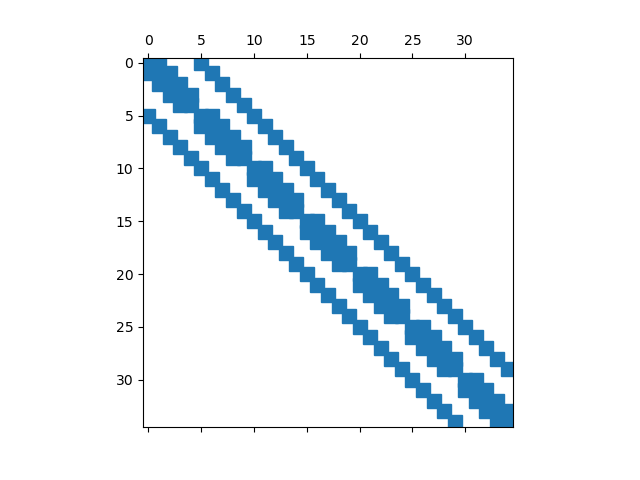

In [5]:
plt.spy(L)

## Solución al problema

Se definen los datos del problema:

In [6]:
Lx    =  31   # [m]      ancho de la lona en la dirección x
Ly    =  31   # [m]      ancho de la lona en la dirección y
T     = 500   # [N/m]    tracción por unidad de longitud
m     = 0.1   # [kg/m^2] masa por unidad de área de la lona
g     = 9.81  # [m/s^2]  aceleración de la gravedad
delta = 1     # [m]      para la diferencias finitas 
amc   = 0.8   # [m]      altura del mástil central
aml   = 0.5   # [m]      altura de los mástiles laterales

# se definen la cantidad de nodos en cada dirección
Nx = int(Lx/delta - 1)
Ny = int(Ly/delta - 1)

Se define la frontera inferior del problema `w_inf` (suelo y mástiles que soportan la carga). Esta frontera es un límite inferior en el problema de minimización, es decir $w_\text{inf}(x,y) \leq w(x,y)$ para todo $(w,y) \in D$, donde $D$ es el dominio de $w$:

In [7]:
# se define la restricción inferior vec_w_inf:
# el suelo y la altura de los mástiles determinan una restricción inferior 
# en la minimización

# se especifica la altura del suelo
w_inf = zeros((Ny, Nx))

# se especifica la posición y la altura del mástil central
# NOTA: el -1 es para hacer este comando igual a MATLAB
idx = round(arange(15, 16+delta, delta)/delta).astype(int) - 1
w_inf[ix_(idx, idx)] = amc

# se especifica la posición y la altura de los cuatro mástiles laterales
# NOTA: el -1 es para hacer este comando igual a MATLAB
idx = round(concatenate([arange(5, 6+delta, delta), arange(25, 26+delta, delta)])/delta).astype(int) - 1
w_inf[ix_(idx, idx)] = aml

Se calcula la posición de los apoyos:

In [8]:
x = arange(0, Lx+delta, delta)
y = arange(0, Ly+delta, delta)
xx, yy = meshgrid(x, y)

apoyos = zeros((Ny+2, Nx+2))
apoyos[1:-1, 1:-1] = w_inf

Graficamos el suelo y los mástiles que soportan la carpa:

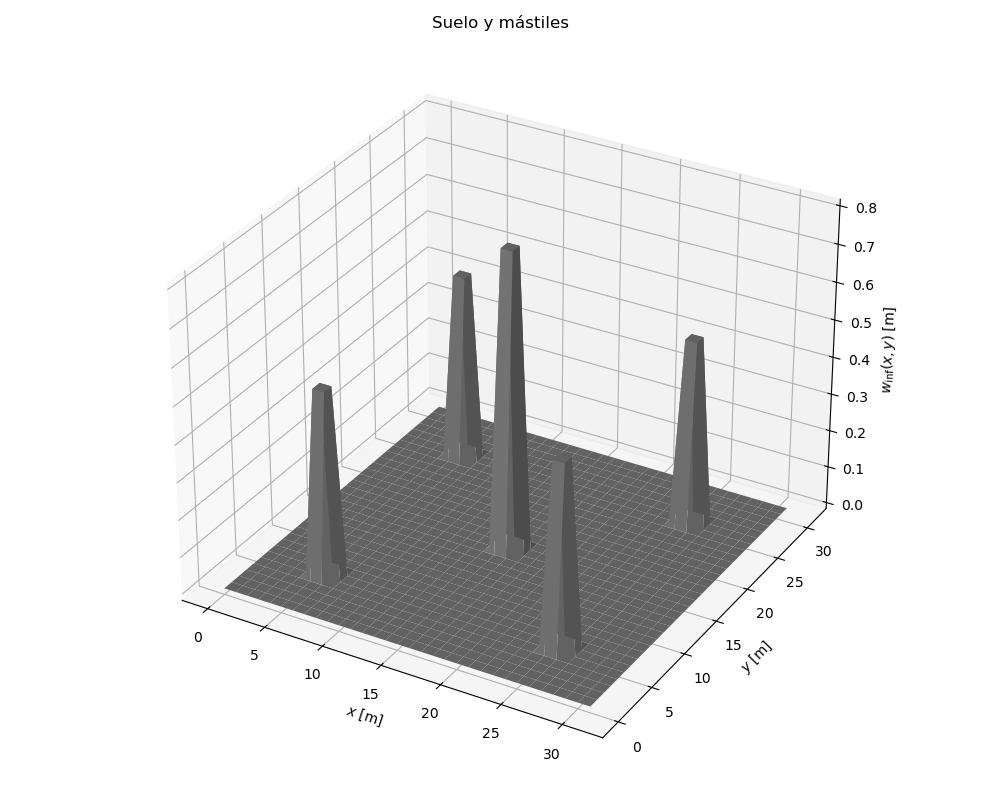

In [9]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# se grafica el suelo y los mástiles que soportan la carpa
ax.plot_surface(xx, yy, apoyos, color='gray')

ax.set_title('Suelo y mástiles')
ax.set_xlabel(r'$x$ [m]')
ax.set_ylabel(r'$y$ [m]')
ax.set_zlabel(r'$w_\text{inf}(x,y)$ [m]')
plt.tight_layout()
plt.show()

Se plantea el problema de optimización:
$$
\Pi(\ve{w}) = \frac{\ve{w}^T\ma{Q}\ve{w}}{2} + \ve{c}^T\ve{w}
$$
sujeto a la restricción
$$
\ve{w}_\text{inf} \leq \ve{w}
$$

Podemos aprovecharnos de este hecho al tener en cuenta que este es un problema de optimización cuadrática, para la cual existen algoritmos de optimización muy eficientes numéricamente hablando.

In [10]:
# la matriz w_inf se debe convertir a vector
vec_w_inf = w_inf.flatten('F')

In [11]:
num_nodos_int = zeros((Ny+2, Nx+2), dtype=int)
num_nodos_int[1:-1, 1:-1] = arange(1, Nx*Ny+1).reshape(Ny, Nx, order='F')

In [12]:
Q = T * mi_delsq(num_nodos_int)
c = delta**2 * m*g*np.ones(Nx*Ny)

### Método 1: utilizando la librería qpsolvers (método eficiente)

En mi computador se demora 336 ms.

Para instalar la librería `qpsolvers`, utilice el comando:

```
conda install -c conda-forge qpsolvers
```

In [13]:
%%time
from qpsolvers import solve_qp
w_ast = solve_qp(Q, c, lb=vec_w_inf, solver="proxqp")

CPU times: user 314 ms, sys: 4.12 ms, total: 318 ms
Wall time: 317 ms


In [14]:
w_ast[0:9]

array([0.01191148, 0.02480396, 0.03789647, 0.04982711, 0.05839059, 0.06136886, 0.0589565 , 0.05352968, 0.04731433])

### Método 2: utilizando la función scipy.optimize.minimize (método ineficiente)

En mi computador se demora 42 s.

In [15]:
# y se restaura la solución a la forma original y se incluye el 
# desplazamiento en la frontera, cuyo valor se conoce y es igual a cero
w = zeros((Ny+2, Nx+2))
w[1:-1, 1:-1] = w_ast.reshape(Ny, Nx, order='F')

/home/daalvarez/anaconda3/lib/python3.11/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


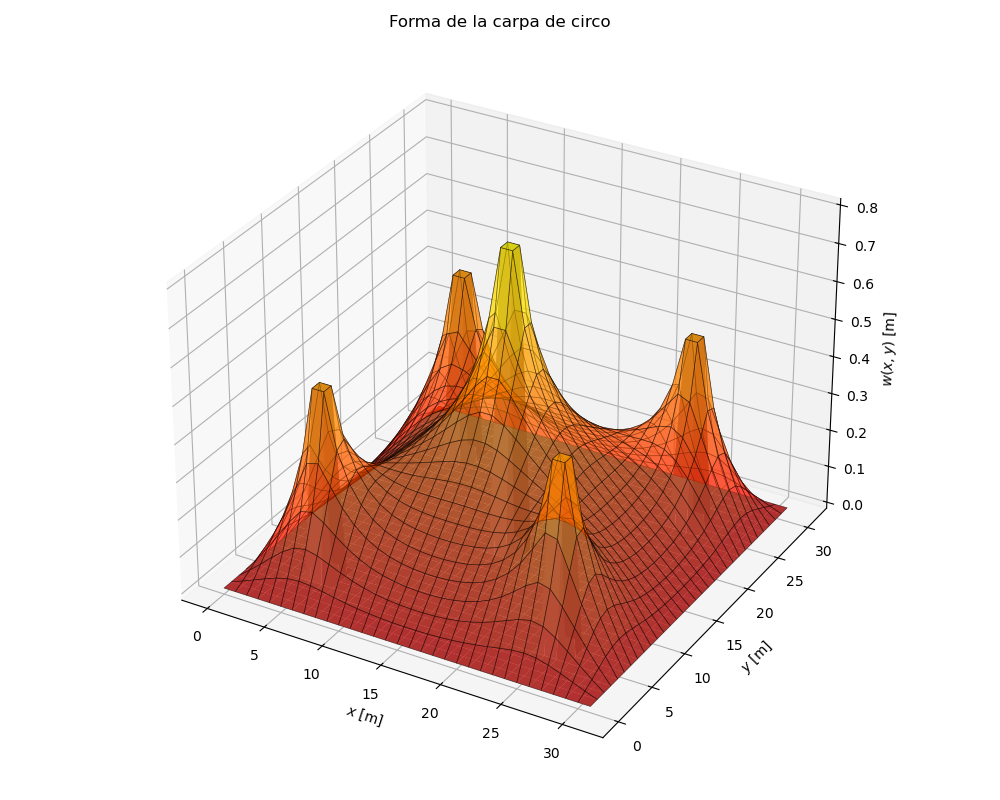

In [16]:
# se grafica la solución
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# se grafica el suelo y los mástiles que soportan la carpa
ax.plot_surface(xx, yy, apoyos, color='gray')

# se grafica la forma de la carpa de circo
ax.plot_surface(xx, yy, w, cmap='autumn', alpha=0.5, edgecolor='k', linewidth=0.5)

ax.set_title('Forma de la carpa de circo')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$w(x,y)$ [m]')
plt.tight_layout()
plt.show()